### Assignment Week 6

The first step is to read data from dat file.

In [73]:
#import libraries
import pandas as pd
from pandas.compat import StringIO
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re

#import data from dat file using StringIO library

temp=u"""
 1 1 1 1 1 1 0 1 1 0 0 0 0 0
 1 1 1 0 1 1 1 1 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 1 0 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 1 0 1 1 1
 0 0 0 0 0 0 1 1 1 1 0 1 1 1
 0 0 0 0 0 1 1 0 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0"""

women = ['EVELYN','LAURA','THERESA','BRENDA','CHARLOTTE','FRANCES','ELEANOR','PEARL','RUTH','VERNE','MYRNA','KATHERINE','SYLVIA','NORA','HELEN','DOROTHY','OLIVIA','FLORA']
events_names = ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14'] 

#reads data to pandas data frame
df = pd.read_csv(StringIO(temp), 
                 sep = "\s+", 
                 names = events_names)


df.set_index(pd.Index(women),inplace = True)

The next step is to translate two-mode graph network to one-mode graph network. The firts option is to build weighted graph where nodes represent women while the second approach is to build weighted graph where nodes represent events.

In [74]:
#build weighted graph where nodes represent women 

participants=[]

for event in list(df.columns):
    #finds out event's participant
    participant =list(df[df.loc[:,event]==1].index)
    #stores lists of participants for each event
    participants.append(participant)


In [75]:
#finds all combinations of two participants
from itertools import combinations 
  
friends_pairs_list=[]
for friends_set in participants: 
    friends_pairs = list(combinations(friends_set, 2))
    friends_pairs_list+=friends_pairs

In [76]:
#stores graph edges
friends = pd.DataFrame(friends_pairs_list,columns=['friend1','friend2'])
friends.head()

,friend1,friend2
0,EVELYN,LAURA
1,EVELYN,BRENDA
2,LAURA,BRENDA
3,EVELYN,LAURA
4,EVELYN,THERESA


In [77]:
#calculates edges weights
weights = friends.groupby(['friend1','friend2']).size().reset_index()
weights.columns = ['friend1','friend2','weight']

weights.sort_values('weight', ascending=False).head(10)

,friend1,friend2,weight
45,EVELYN,THERESA,7
38,EVELYN,LAURA,6
116,THERESA,BRENDA,6
114,SYLVIA,NORA,6
113,SYLVIA,HELEN,6
89,NORA,HELEN,6
65,KATHERINE,SYLVIA,6
30,EVELYN,BRENDA,6
66,LAURA,BRENDA,6
78,LAURA,THERESA,6


The table above shows women that most probaly became friens since they met with each other more friquently than with the other women.

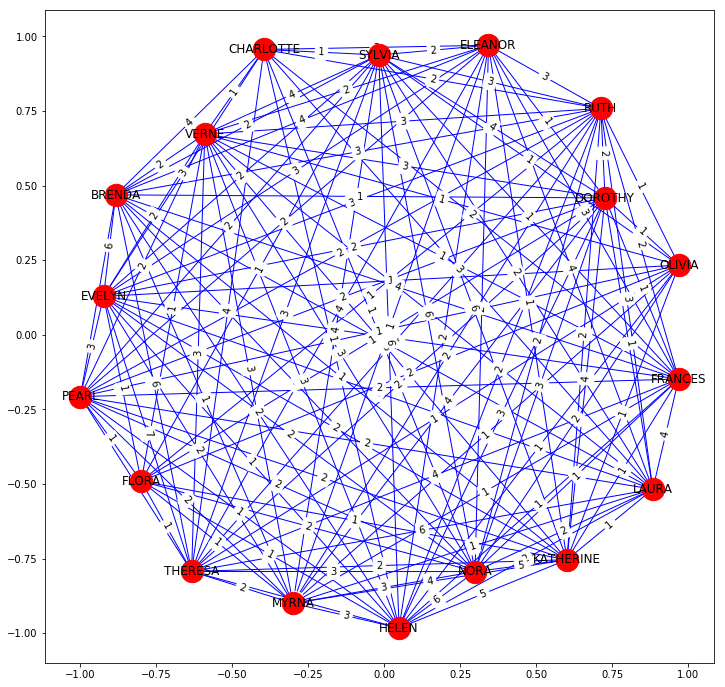

In [78]:
#creates empty graph
G = nx.Graph()

#adds nodes with the node attribute "bipartite"
G.add_nodes_from(women)

edges = weights[['friend1','friend2','weight']].values.tolist()
#adds edges
i=0
for item in edges:
    G.add_edge(item[0],item[1],weight=item[2])

#select layout
pos = nx.spring_layout(G,k=10)

#adjust size of th graph
plt.figure(figsize = (12,12))

#pos=nx.get_node_attributes(G,'pos')      
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'r', node_size = 500)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

#display graph
plt.show()

In [79]:
#calculates edge betweenness centrality
edge_betweenness_centrality_values = nx.edge_betweenness_centrality(G)
edge_betweenness_centrality_list =list()
for k,v in edge_betweenness_centrality_values.items():
      edge_betweenness_centrality_list.append(v)
weights['edge betweenness centrality'] = edge_betweenness_centrality_list
weights['edge betweenness centrality']=round(weights['edge betweenness centrality'],5)
weights.sort_values('edge betweenness centrality', ascending=False,inplace=True)
weights.head(10)

,friend1,friend2,weight,edge betweenness centrality
61,KATHERINE,FLORA,1,0.01078
62,KATHERINE,HELEN,5,0.01078
1,BRENDA,DOROTHY,1,0.01078
60,KATHERINE,DOROTHY,4,0.01078
63,KATHERINE,NORA,5,0.01078
64,KATHERINE,OLIVIA,1,0.01078
32,EVELYN,DOROTHY,2,0.01078
95,PEARL,KATHERINE,2,0.00985
41,EVELYN,OLIVIA,1,0.00985
104,RUTH,HELEN,2,0.00985


The table above shows edges with highest edge betweenness centrality scores. Those edges represent a bridge-like connector between two parts of a network, and the removal of which may affect the communication between many pairs of women through the shortest paths between them. 

In [80]:
#build weighted graph where nodes represent events

women_event_set=[]

for woman in list(df.index):
    #calculates set of events that a woman attended
    woman_event_set =list(df.loc[woman][df.loc[woman]==1].index)
    #stores set of events for each woman
    women_event_set.append(woman_event_set)
    

events_pairs_list=[]

#finds all combinations of two events
for events_set in women_event_set: 
    events_pairs= list(combinations(events_set, 2))
    events_pairs_list += events_pairs    
    
#stores graph edges
events = pd.DataFrame(events_pairs_list,columns=['event1','event2'])
events.head()

#calculates edges weights
weights = events.groupby(['event1','event2']).size().reset_index()
weights.columns = ['event1','event2','weight']

weights.sort_values('weight', ascending=False).head(10)    

,event1,event2,weight
60,E8,E9,9
53,E7,E8,8
38,E5,E8,7
46,E6,E8,7
37,E5,E7,6
36,E5,E6,6
63,E9,E12,6
9,E10,E12,6
57,E8,E12,6
26,E3,E5,6


The table above shows the number of common participants for a pair of events.  For example, the maximum number of women with similar interests attended events 'E8' and 'E9'.

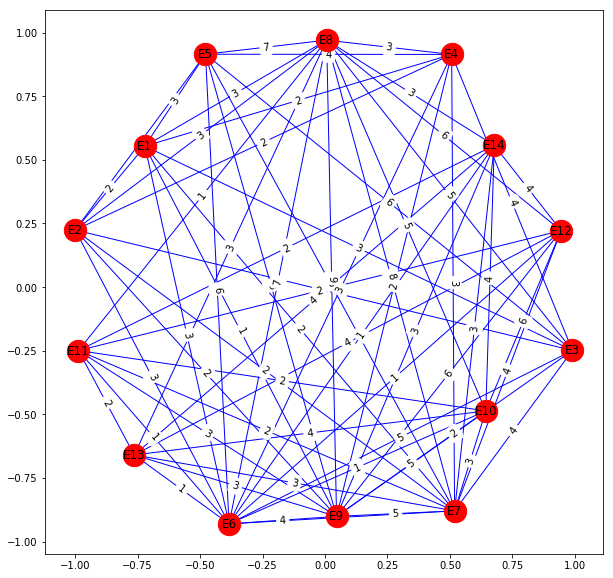

In [81]:
#creates empty graph
G = nx.Graph()

#adds nodes with the node attribute "bipartite"
G.add_nodes_from(events_names)

edges = weights[['event1','event2','weight']].values.tolist()
#adds edges
i=0
for item in edges:
    G.add_edge(item[0],item[1],weight=item[2])

#select layout
pos = nx.spring_layout(G,k=10)

#adjust size of th graph
plt.figure(figsize = (10,10))

#pos=nx.get_node_attributes(G,'pos')      
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = 'r', node_size = 500)

labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows=True)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

#display graph
plt.show()

In [82]:
#calculates edge betweenness centrality
edge_betweenness_centrality_values = nx.edge_betweenness_centrality(G)
edge_betweenness_centrality_list =list()
for k,v in edge_betweenness_centrality_values.items():
      edge_betweenness_centrality_list.append(v)
weights['edge betweenness centrality'] = edge_betweenness_centrality_list
weights['edge betweenness centrality']=round(weights['edge betweenness centrality'],5)
weights.sort_values('edge betweenness centrality', ascending=False,inplace=True)
weights.head(10)

,event1,event2,weight,edge betweenness centrality
33,E4,E7,3,0.02473
24,E2,E9,2,0.02473
27,E3,E6,5,0.02473
28,E3,E7,4,0.02473
29,E3,E8,5,0.02473
30,E3,E9,2,0.02473
31,E4,E5,4,0.02473
32,E4,E6,3,0.02473
34,E4,E8,3,0.02473
55,E8,E10,5,0.02473


The table above shows edges with highest edge betweenness centrality scores. Those edges represent a bridge-like connector between two parts of a network, and the removal of which may affect the communication between many pairs of events through the shortest paths between them. 